### Introduction and Motivation

For our ENSF 612 project, we trained various models to predict the total ride duration of taxi trips in New York City (NYC). We chose to study this dataset because it offered insights into traffic patterns in one of the world's fastest-moving cities.

Our dataset was sourced from [Kaggle](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data?select=train.zip). The dataset was cleaned specifically for a competition, enabling our group to concentrate on exploratory data analysis (EDA) and model building.

In this notebook, we focused on clustering pickup and drop-off coordinates and one-hot encoding from the dataset exported from `eda-data-cleaning,` which is named `train_cleaned.`

### Connect to drive

In [ ]:
# connect to collab
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# record time
import time

# start record
start = time.time()

Mounted at /content/drive


In [ ]:
# root directories
BASE_PATH = "/content/drive/MyDrive/Colab Notebooks/ENSF 612/project"

MEDIA_PATH = BASE_PATH  + "/media"
DATASET_PATH = BASE_PATH + "/dataset"

In [ ]:
# NYC dataset
TRAIN_DATASET = DATASET_PATH + "/" + "train_cleaned.csv"

### Library imports

In [ ]:
# normal imports
import os
import requests
from IPython.display import Image

# for dataframes
import numpy as np
import pandas as pd

# plots
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

# geodesic
from geopy.distance import geodesic

# calculation
from math import radians, cos, sin, asin, sqrt

from graphviz import Digraph

### Setup Spark

In [ ]:
# Install Java Development Kit (required for Apache Spark)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download and extract Apache Spark (version 3.5.0) with Hadoop (version 3)
!wget -q https://dlcdn.apache.org/spark/spark-3.5.0/spark-3.5.0-bin-hadoop3.tgz
!tar -xf spark-3.5.0-bin-hadoop3.tgz

# Install the findspark library (used to locate and initialize Apache Spark)
!pip install -q findspark

# Set up the required environment variables for Java and Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.0-bin-hadoop3"

In [ ]:
# Initialize findspark and import SparkSession
import findspark
findspark.init()

In [ ]:
# eda
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, dayofweek, hour, count, when, year, month, minute, quarter, monotonically_increasing_id, avg
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, TimestampType
from pyspark.sql import functions as F
from pyspark.sql import types as T

# machine learning
from pyspark.ml.feature import VectorAssembler, StandardScaler, OneHotEncoder, StringIndexer, PolynomialExpansion, PCA
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor, LinearRegressionModel, GBTRegressor
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator
from pyspark.ml.clustering import KMeans

In [ ]:
# Create a Spark session and context
spark = SparkSession.builder.master("local").appName("Colab").config('spark.ui.port', '4050').getOrCreate()
sc = spark.sparkContext

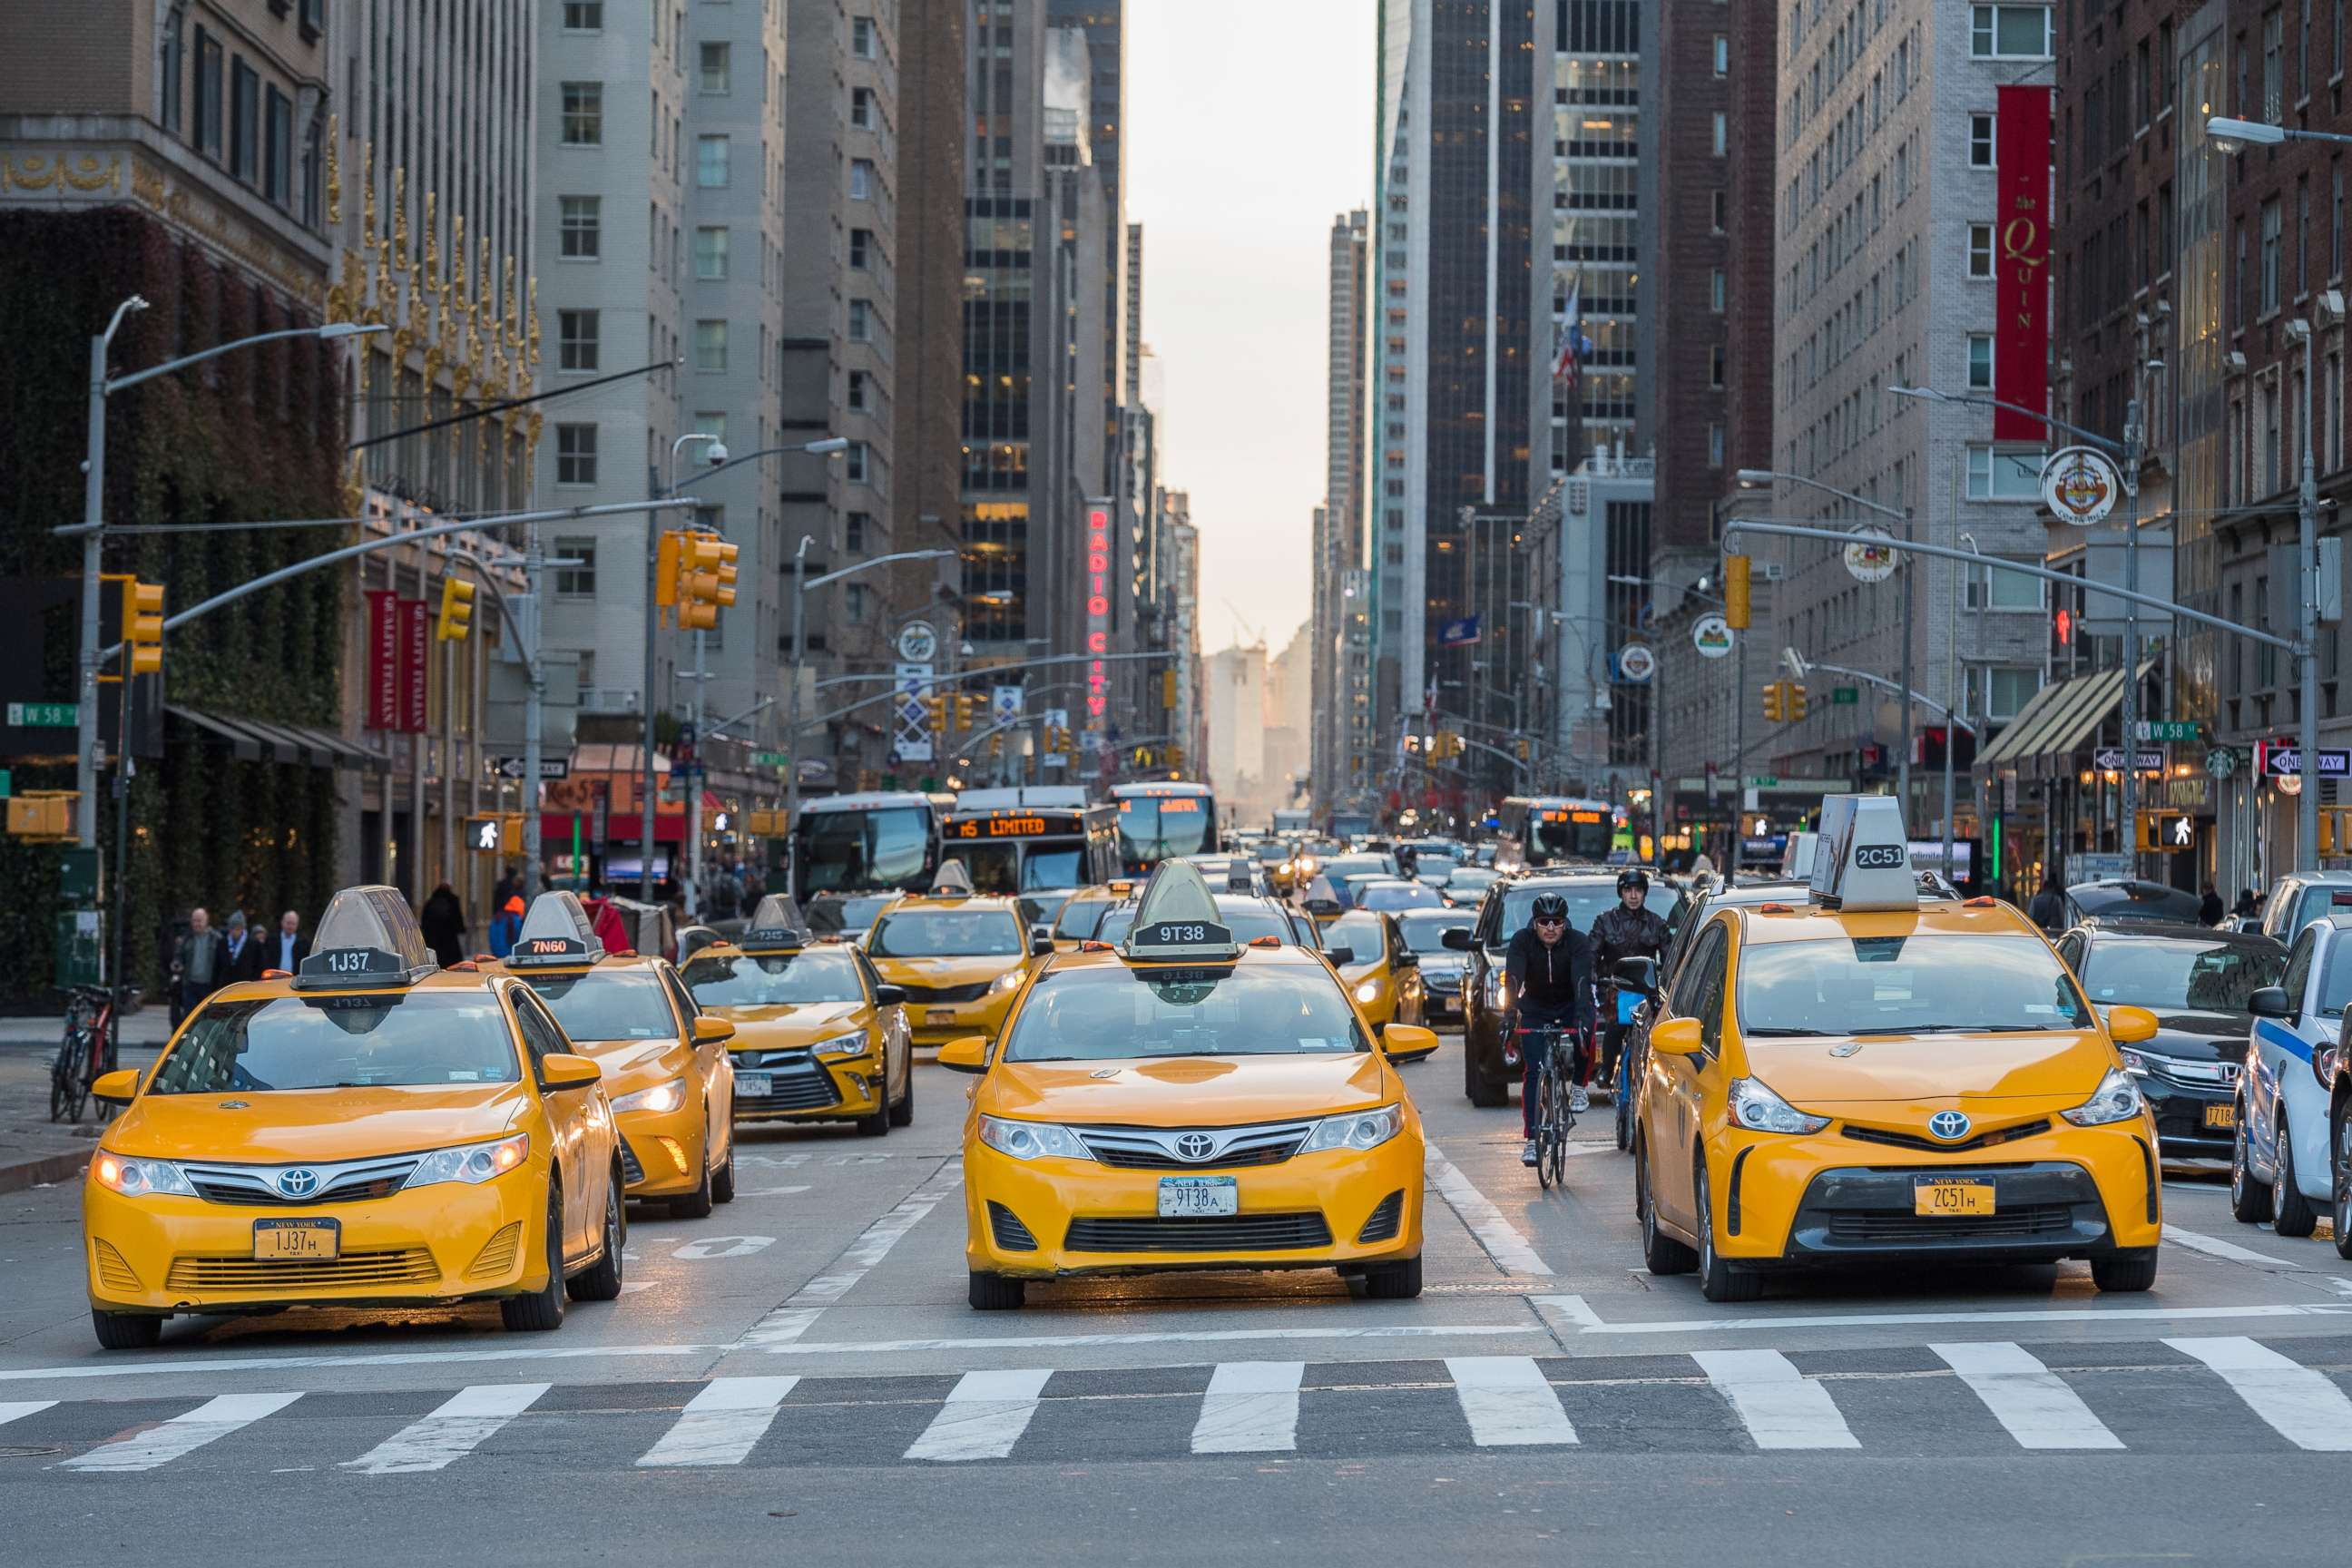

In [ ]:
nyc_image = MEDIA_PATH + "/nyc_image.jpg"
display(Image(filename=nyc_image))

### Read CSV

In [ ]:
schema = StructType([
    StructField("passenger_count", IntegerType(), True),
    StructField("pickup_longitude", FloatType(), True),
    StructField("pickup_latitude", FloatType(), True),
    StructField("dropoff_longitude", FloatType(), True),
    StructField("dropoff_latitude", FloatType(), True),
    StructField("trip_duration", FloatType(), True),
    StructField("distance", FloatType(), True),
    StructField("year", IntegerType(), True),
    StructField("quarter_of_year", IntegerType(), True),
    StructField("month", IntegerType(), True),
    StructField("week_day", IntegerType(), True),
    StructField("hour", IntegerType(), True),
    StructField("minute", IntegerType(), True),
])

# Read the CSV file into a DataFrame
taxi_df = spark.read.csv(TRAIN_DATASET, schema=schema, header=True)
taxi_df.show(5)

+---------------+----------------+---------------+-----------------+----------------+-------------+---------+----+---------------+-----+--------+----+------+
|passenger_count|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|trip_duration| distance|year|quarter_of_year|month|week_day|hour|minute|
+---------------+----------------+---------------+-----------------+----------------+-------------+---------+----+---------------+-----+--------+----+------+
|              1|      -73.980415|      40.738564|        -73.99948|        40.73115|        663.0|1.8055072|2016|              2|    6|       1|   0|    43|
|              1|       -73.97903|       40.76394|        -74.00533|       40.710087|       2124.0|6.3850985|2016|              1|    1|       3|  11|    35|
|              1|       -73.96928|       40.79778|        -73.92247|        40.76056|       1551.0|5.7149806|2016|              2|    5|       7|   7|    54|
|              1|       -73.98105|       40.74434|  

In [ ]:
taxi_df_clusters = taxi_df.drop("passenger_count")

### One-Hot Encoding
During EDA, we observed that the trends throughout the week remained consistent. We anticipated that this encoding would lead to model improvement due to the reduced weight on the feature.

In [ ]:
# trying to copy get dummies from sklearn
days = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]

for i, day in enumerate(days, start=1):
    taxi_df_clusters = taxi_df_clusters.withColumn(day, when(col("week_day") == i, 1).otherwise(0))

# Now df has 7 additional columns
taxi_df_clusters = taxi_df_clusters.drop("week_day")
taxi_df_clusters.show(5)

+----------------+---------------+-----------------+----------------+-------------+---------+----+---------------+-----+----+------+------+------+-------+---------+--------+------+--------+
|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|trip_duration| distance|year|quarter_of_year|month|hour|minute|Sunday|Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|
+----------------+---------------+-----------------+----------------+-------------+---------+----+---------------+-----+----+------+------+------+-------+---------+--------+------+--------+
|      -73.980415|      40.738564|        -73.99948|        40.73115|        663.0|1.8055072|2016|              2|    6|   0|    43|     1|     0|      0|        0|       0|     0|       0|
|       -73.97903|       40.76394|        -74.00533|       40.710087|       2124.0|6.3850985|2016|              1|    1|  11|    35|     0|     0|      1|        0|       0|     0|       0|
|       -73.96928|       40.79778|        -73.9224

### Clustering
We used KMeans clustering to assign **pickup neighborhood** and **dropoff neighborhood** to each sample. The **pickup/dropoff coordinates** were clustered using 480 neighbors, mirroring the 480 zip codes in NYC.

In [ ]:
vec_assembler = VectorAssembler(inputCols=["pickup_longitude", "pickup_latitude"], outputCol="pickup")
taxi_df_clusters = vec_assembler.transform(taxi_df_clusters)

In [ ]:
vec_assembler = VectorAssembler(inputCols=["dropoff_longitude", "dropoff_latitude"], outputCol="dropoff")
taxi_df_clusters = vec_assembler.transform(taxi_df_clusters)
taxi_df_clusters.show(5)

+----------------+---------------+-----------------+----------------+-------------+---------+----+---------------+-----+----+------+------+------+-------+---------+--------+------+--------+--------------------+--------------------+
|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|trip_duration| distance|year|quarter_of_year|month|hour|minute|Sunday|Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|              pickup|             dropoff|
+----------------+---------------+-----------------+----------------+-------------+---------+----+---------------+-----+----+------+------+------+-------+---------+--------+------+--------+--------------------+--------------------+
|      -73.980415|      40.738564|        -73.99948|        40.73115|        663.0|1.8055072|2016|              2|    6|   0|    43|     1|     0|      0|        0|       0|     0|       0|[-73.980415344238...|[-73.999481201171...|
|       -73.97903|       40.76394|        -74.00533|       40.710087|   

In [ ]:
scaler = StandardScaler(inputCol="pickup", outputCol="scaled_pickup")
taxi_df_clusters = scaler.fit(taxi_df_clusters).transform(taxi_df_clusters)
taxi_df_clusters.show(5)

+----------------+---------------+-----------------+----------------+-------------+---------+----+---------------+-----+----+------+------+------+-------+---------+--------+------+--------+--------------------+--------------------+--------------------+
|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|trip_duration| distance|year|quarter_of_year|month|hour|minute|Sunday|Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|              pickup|             dropoff|       scaled_pickup|
+----------------+---------------+-----------------+----------------+-------------+---------+----+---------------+-----+----+------+------+------+-------+---------+--------+------+--------+--------------------+--------------------+--------------------+
|      -73.980415|      40.738564|        -73.99948|        40.73115|        663.0|1.8055072|2016|              2|    6|   0|    43|     1|     0|      0|        0|       0|     0|       0|[-73.980415344238...|[-73.999481201171...|[-1678.767

In [ ]:
scaler = StandardScaler(inputCol="dropoff", outputCol="scaled_dropoff")
taxi_df_clusters = scaler.fit(taxi_df_clusters).transform(taxi_df_clusters)
taxi_df_clusters.show(5)

+----------------+---------------+-----------------+----------------+-------------+---------+----+---------------+-----+----+------+------+------+-------+---------+--------+------+--------+--------------------+--------------------+--------------------+--------------------+
|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|trip_duration| distance|year|quarter_of_year|month|hour|minute|Sunday|Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|              pickup|             dropoff|       scaled_pickup|      scaled_dropoff|
+----------------+---------------+-----------------+----------------+-------------+---------+----+---------------+-----+----+------+------+------+-------+---------+--------+------+--------+--------------------+--------------------+--------------------+--------------------+
|      -73.980415|      40.738564|        -73.99948|        40.73115|        663.0|1.8055072|2016|              2|    6|   0|    43|     1|     0|      0|        0|       0|     

In [ ]:
k = 480
kmeans = KMeans().setK(k)
kmeans = kmeans.setFeaturesCol("scaled_pickup")
model = kmeans.fit(taxi_df_clusters)

In [ ]:
taxi_df_clusters = model.transform(taxi_df_clusters)
taxi_df_clusters = taxi_df_clusters.withColumnRenamed("prediction", "pickup_neighbourhood")
taxi_df_clusters.show(5)

+----------------+---------------+-----------------+----------------+-------------+---------+----+---------------+-----+----+------+------+------+-------+---------+--------+------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|trip_duration| distance|year|quarter_of_year|month|hour|minute|Sunday|Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|              pickup|             dropoff|       scaled_pickup|      scaled_dropoff|pickup_neighbourhood|
+----------------+---------------+-----------------+----------------+-------------+---------+----+---------------+-----+----+------+------+------+-------+---------+--------+------+--------+--------------------+--------------------+--------------------+--------------------+--------------------+
|      -73.980415|      40.738564|        -73.99948|        40.73115|        663.0|1.8055072|2016|              2| 

In [ ]:
kmeans = kmeans.setFeaturesCol("scaled_dropoff")
model = kmeans.fit(taxi_df_clusters)
taxi_df_clusters = model.transform(taxi_df_clusters)
taxi_df_clusters = taxi_df_clusters.withColumnRenamed("prediction", "dropoff_neighbourhood")

In [ ]:
taxi_df_clusters_final = taxi_df_clusters.drop("pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "pickup", "dropoff", "scaled_pickup", "scaled_dropoff")
taxi_df_clusters_final.show(5)

+-------------+---------+----+---------------+-----+----+------+------+------+-------+---------+--------+------+--------+--------------------+---------------------+
|trip_duration| distance|year|quarter_of_year|month|hour|minute|Sunday|Monday|Tuesday|Wednesday|Thursday|Friday|Saturday|pickup_neighbourhood|dropoff_neighbourhood|
+-------------+---------+----+---------------+-----+----+------+------+------+-------+---------+--------+------+--------+--------------------+---------------------+
|        663.0|1.8055072|2016|              2|    6|   0|    43|     1|     0|      0|        0|       0|     0|       0|                  92|                  335|
|       2124.0|6.3850985|2016|              1|    1|  11|    35|     0|     0|      1|        0|       0|     0|       0|                 441|                  111|
|       1551.0|5.7149806|2016|              2|    5|   7|    54|     0|     0|      0|        0|       0|     0|       1|                  80|                  152|
|       12

In [ ]:
taxi_df_clusters_final.printSchema()

root
 |-- trip_duration: float (nullable = true)
 |-- distance: float (nullable = true)
 |-- year: integer (nullable = true)
 |-- quarter_of_year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- minute: integer (nullable = true)
 |-- Sunday: integer (nullable = false)
 |-- Monday: integer (nullable = false)
 |-- Tuesday: integer (nullable = false)
 |-- Wednesday: integer (nullable = false)
 |-- Thursday: integer (nullable = false)
 |-- Friday: integer (nullable = false)
 |-- Saturday: integer (nullable = false)
 |-- pickup_neighbourhood: integer (nullable = false)
 |-- dropoff_neighbourhood: integer (nullable = false)



In [ ]:
# export notebook
save_filename = DATASET_PATH + "/train_cleaned_clustered.csv"

taxi_df_clusters_final.write.mode("overwrite").csv(save_filename, header=True)

### End of notebook

In [ ]:
end = time.time()
delta_time = end - start
print(F"It took {delta_time} s to run the notebook.")

It took 686.2853317260742 s to run the notebook.
